# Analysis 1
- Model: CoxPH 
- Feature selection: Significant variables based on univariate analysis
- Drop patients with missing sex 
- Predicts 5 year risk for combined UGI cancer
- Risk score threshold determined on 1) 4th quartile and 2) optimal threshold 

## Import libraries

In [ ]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix
from scipy.stats import percentileofscore
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path
from functools import reduce

In [ ]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [ ]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [ ]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(broom.helpers)
library(purrr)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [ ]:
%%R 
r_df_normal <- read.csv("df_analysis0.csv")

In [ ]:
univariate_filename = './../results/univariate_analysis_1.csv'
multivariate_filename = './../results/multivariate_analysis_1.csv'
validation_set_filename = './../data/validation_set.csv'
risk_results_filename = './../results/risk_results_analysis_1.csv'

In [ ]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean']
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)
ro.globalenv['validation_set_filename'] = str(validation_set_filename)

## Univariate analysis

In [ ]:
%%R 
# Ignore these columns
cols_to_ignore <- c(
    'months_to_event', 'ugica', 'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC', 
    'death', 'subtype', 'visit_year', 'diagnosis_year', 'encounter_type', 'social_language', 
    'days_to_event', 'days_to_dx', 'days_to_death',
    "eac_risk_factors_screening", "meets_screening",
    "hgball_baseline_imputed_mean"
)

subtype_outcomes <- c('ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC')

### Factorize categorical vars and set reference levels

In [ ]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
# r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
# r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
# r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
# r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [ ]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex"                           "sex_missing"                  
 [3] "race_clean"                    "race_clean_missing"           
 [5] "ethnicity"                     "ethnicity_missing"            
 [7] "alcohol_all"                   "alcohol_binary"               
 [9] "tobacco_all"                   "tobacco_all_missing"          
[11] "tobacco_binary"                "tobacco_binary_missing"       
[13] "hpylori_active"                "hpylori_active_chronic"       
[15] "hpylori_active_chronic_binary" "hnca"                         
[17] "achalasia"                     "pud"                          
[19] "gerd"                          "cad"                          
[21] "barretts"                      "famhx_cancer"                 
[23] "famhx_esophagealca"            "famhx_gastricca"              
[25] "famhx_colonca"                 "famhx_barretts"               
[27] "ASA"                           "PPI"                          
[29] "NSAID"                      

In [ ]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]

# HRs, 95% CIs, p-values
results_list <- list()

for (i in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[i]]))) < 2) next

    # Build formula
    formula <- as.formula(paste("Surv(months_to_event, ugica) ~", i))
    
    model <- coxph(formula, data=r_df_normal)

    model_summary <- summary(model)
    coef <- exp(model_summary$coef[, "coef"])
    confint_vals <- exp(confint(model))
    p_value <- model_summary$coef[, "Pr(>|z|)"]

    # Extract full term names (e.g., "sexMale", "stageIII")
    terms <- rownames(model_summary$coef)

    # Extract factor levels (remove variable name prefix)
    is_factor <- i %in% categorical_vars
    levels_clean <- if (is_factor) {
        sub(paste0("^", i), "", terms)
    } else {
        terms  # use full term name for numeric variables
    }

    model_df <- data.frame(
        Variable = i,
        Level = levels_clean,
        HR = coef,
        CI_lower = confint_vals[, 1],
        CI_upper = confint_vals[, 2],
        p_value = p_value
    )

    results_list[[i]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

In [ ]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [ ]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,HR,CI_lower,CI_upper,p_value
0,sex.sexMALE,sex,MALE,1.981637,1.558041,2.520398,2.492422e-08
2,sex_missing,sex_missing,MALE,1.981637,1.558041,2.520398,2.492423e-08
3,race_clean.race_cleanAsian,race_clean,Asian,1.746678,1.140449,2.675161,1.034142e-02
4,race_clean.race_cleanBlack or African American,race_clean,Black or African American,0.719336,0.524997,0.985612,4.034913e-02
7,race_clean_missing.race_clean_missingAsian,race_clean_missing,Asian,1.744918,1.139282,2.672507,1.048309e-02
8,race_clean_missing.race_clean_missingBlack or ...,race_clean_missing,Black or African American,0.719282,0.524956,0.985543,4.030657e-02
11,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.648537,0.421466,0.997946,4.891696e-02
14,alcohol_all.alcohol_all2.0,alcohol_all,2.0,2.022517,1.418195,2.884354,1.005934e-04
15,alcohol_all.alcohol_allNo matching concept,alcohol_all,No matching concept,1.660128,1.243813,2.215788,5.793235e-04
16,alcohol_binary,alcohol_binary,1,1.402518,1.074902,1.829986,1.269920e-02


## Feature selection

In [ ]:
%%R 
selected_vars <- final_results %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% c("sex", "race_clean_missing", "alcohol_binary") & # , "famhx_cancer", "famhx_gastricca", "famhx_colonca"
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"     "race_clean"      "ethnicity"       "alcohol_all"    
 [5] "pud"             "gerd"            "cad"             "barretts"       
 [9] "famhx_cancer"    "famhx_gastricca" "famhx_colonca"   "ASA"            
[13] "PPI"            


## CoxPH multivariate model training

In [ ]:
%%R 
library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica, all_of(subtype_outcomes), all_of(selected_vars)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(rdf$ugica)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica)))  # Validation set
  cat("\n")

  list(train_set = train_set, validation_set = validation_set)
}

# Trains model
train_model <- function(train_set, selected_vars, model_func = coxph) {
  formula_str <- paste("Surv(months_to_event, ugica) ~", paste(selected_vars, collapse = " + "))
  formula <- as.formula(formula_str)
  model <- model_func(formula, data = train_set)
  return(model)
}

# Saves multivariate analysis into filename
save_multivariate_results <- function(cox_model, multivariate_filename, variable_labels) {

  # Tidy model with variable and level parsed
  multivariate_df <- tidy_plus_plus(
    cox_model, 
    exponentiate = TRUE,
    variable_labels = variable_labels
  ) %>%
  mutate(
      HR_scaled = estimate / min(estimate, na.rm = TRUE),
      HR_rank = round(HR_scaled)
  ) 

  # Save to file
  write.csv(multivariate_df, multivariate_filename, row.names = FALSE)
  cat("Multivariate results saved to", multivariate_filename, "\n")

  return(multivariate_df)
}

# Gets risk estimate
calculate_risk <- function(cox_model, validation_set, horizon_months = 60) {
  baseline_hazard <- basehaz(cox_model, centered = FALSE)
  H0_t <- approx(baseline_hazard$time, baseline_hazard$hazard, xout = horizon_months)$y
  
  linear_predictor <- predict(cox_model, newdata = validation_set, type = "lp")
  H_t_X <- H0_t * exp(linear_predictor)
  risk <- 1 - exp(-H_t_X)
  
  return(risk)
}

# Gets actual event 
count_event <- function(validation_set, outcome, horizon_months = 60) {
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set[[outcome]] == 1)
  return(event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # C-statistic (AUROC)
    roc_obj <- roc(event, risk)
    c_statistic <- auc(roc_obj)

    # Print the results
    cat("C-statistic (AUROC):", round(c_statistic, 3), "\n")
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")
    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 2)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "blue", size = 1.2) +
    geom_abline(linetype = "dashed", color = "gray") +
    annotate("text", x = 0.6, y = 0.1, label = paste("AUROC =", auroc), size = 5) +
    labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
    theme_minimal()
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, group, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


#### Split dataset into training and validation

In [ ]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
cox_model <- train_model(train_set, selected_vars, model_func=coxph)

[1] "Dataset Controls 33871" "Dataset Cases 312"     
[1] "Training Controls 27103" "Training Cases 244"     
[1] "Validation Controls 6768" "Validation Cases 68"     



#### Test proportional hazards assumption

In [ ]:
%%R 
ph_test <- cox.zph(cox_model)
print(ph_test)

                 chisq df      p
sex_missing      0.255  1 0.6136
race_clean       2.829  4 0.5868
ethnicity        1.199  2 0.5490
alcohol_all      0.846  3 0.8384
pud              2.834  1 0.0923
gerd             2.719  1 0.0991
cad              0.725  1 0.3945
barretts         0.429  1 0.5125
famhx_cancer     5.444  1 0.0196
famhx_gastricca  8.245  1 0.0041
famhx_colonca    4.263  1 0.0389
ASA              0.125  1 0.7241
PPI              3.216  1 0.0729
GLOBAL          20.198 19 0.3828


#### Multivariate analysis

In [ ]:
%%R 
# Saves hazard ratio from multivariate analysis into file
variable_labels = c(
    hgball_baseline_imputed_mean = "Hemoglobin", 
    sex_missing = "Sex", 
    race_clean = "Race", 
    ethnicity = "Ethnicity", 
    alcohol_binary = "Alcohol", 
    pud = "Peptic ulcer disease",
    gerd = "GERD",
    cad = "Coronary artery disease", 
    barretts = "Barretts esophagus",
    famhx_cancer = "Family history of cancer",
    famhx_gastricca = "Family history of gastric cancer", 
    famhx_colonca = "Family history of colon cancer",
    ASA = "Aspirin use",
    PPI = "Proton pump inhibitor use"
)
multivariate_df <- save_multivariate_results(cox_model, multivariate_filename, variable_labels)


Multivariate results saved to ./../results/multivariate_analysis_1.csv 


## Results

### Predict events

In [ ]:
%%R 
# Estimate risk
risk_5_years <- calculate_risk(cox_model, validation_set)
event_5_years <- count_event(validation_set, "ugica")

r_df_validation_risk <- data.frame(
    time = validation_set$months_to_event,
    event_ugica = validation_set$ugica,
    event_escc = validation_set$ugica_ESCC,
    event_eac = validation_set$ugica_EAC,
    event_cgc = validation_set$ugica_CGC,
    event_ncgc = validation_set$ugica_NCGC,

    race = validation_set$race_clean,

    pred_risk = risk_5_years,
    
    ugica_5yr = event_5_years,
    escc_5yr = count_event(validation_set, "ugica_ESCC"),
    eac_5yr = count_event(validation_set, "ugica_EAC"),
    cgc_5yr = count_event(validation_set, "ugica_CGC"),
    ncgc_5yr = count_event(validation_set, "ugica_NCGC")
)

# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])


# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.807 
Sensitivity: 0.825 
Specificity: 0.7001177 
PPV: 0.01593433 
NPV: 0.998531 
NNS: 69.13102 
     predicted_class
event    0    1
    0 4758 2038
    1    7   33


In [ ]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,pred_risk,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr
6,59.071869,0,0,0,0,0,No matching concept,0.011515,0.0,0.0,0.0,0.0,0.0
12,4.993840,0,0,0,0,0,No matching concept,0.003627,0.0,0.0,0.0,0.0,0.0
14,66.726899,0,0,0,0,0,White,0.007097,0.0,0.0,0.0,0.0,0.0
23,157.043121,0,0,0,0,0,No matching concept,0.001538,0.0,0.0,0.0,0.0,0.0
25,0.164271,0,0,0,0,0,White,0.024630,0.0,0.0,0.0,0.0,0.0


### Sensitivity and Metrics at threshold that maximizes Youdens

In [ ]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.807 
Sensitivity: 0.8 
Specificity: 0.7522072 
PPV: 0.01864802 
NPV: 0.9984375 
NNS: 58.5291 
     predicted_class
event    0    1
    0 5112 1684
    1    8   32


### AUROC curves and PR curve

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



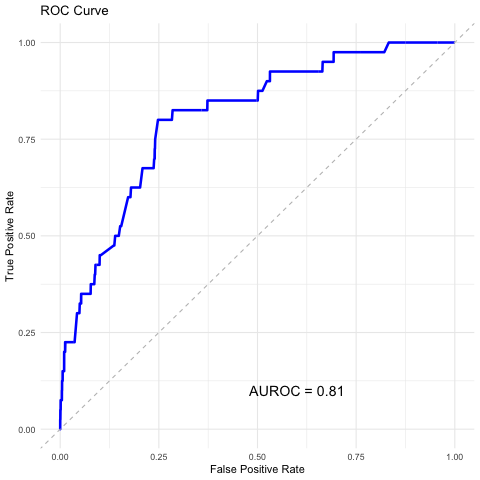

In [ ]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

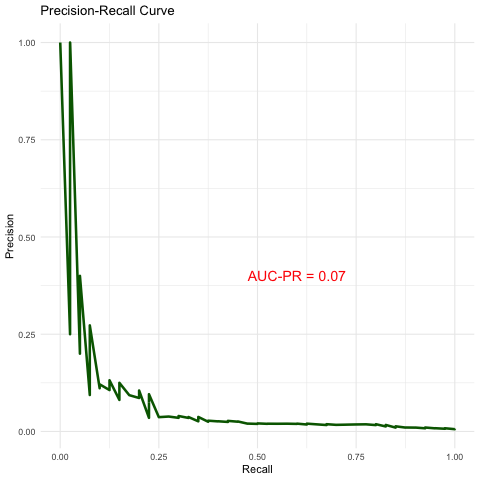

In [ ]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [ ]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)

optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk['pred_risk'], optimal_threshold, kind='weak')/100.

# Example inputs
percentile_cutoffs = [0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]
percentile_high_risk = 0.9 # Chosen percentile for high risk group, can vary to compare  
labels = percentile_cutoffs[1:]

# Assign risk groups based on custom percentile cutoffs
df_validation_risk['risk_group'] = pd.qcut(
    df_validation_risk['pred_risk'],
    q=percentile_cutoffs,
    labels=labels,
    duplicates='drop'  # in case there are tied values
)

# One-hot encoding, create a boolean column for each percentile cutoff
for idx, label in enumerate(labels):
    risk_col = f"risk_p{percentile_cutoffs[idx+1]}"
    include_labels = labels[:idx+1]
    df_validation_risk[risk_col] = np.where(df_validation_risk['risk_group'].isin(include_labels), 0, 1)

# Custom low/high risk cutoff
high_risk_idx = percentile_cutoffs.index(percentile_high_risk)
df_validation_risk['high_risk'] = np.where(df_validation_risk['risk_group'] == labels[high_risk_idx], 1, 0)

# Optimal Youden threshold cutoff
df_validation_risk['high_risk_youden'] = np.where(df_validation_risk['pred_risk'] >= optimal_threshold, 1, 0)


In [ ]:
def classification_metrics(predicted_risk_df, risk_group_name, actual_event_name, race = 'all'):
    predicted_class = predicted_risk_df[risk_group_name]
    actual_class = predicted_risk_df[actual_event_name]

    # Get confusion matrix: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(actual_class, predicted_class).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    youden_index = sensitivity + specificity - 1

    total_in_risk_group = predicted_class.sum()
    total_cases_in_risk_group = tp
    prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1) 

    # Return as dictionary
    return {
        "risk_group": risk_group_name,
        "risk_percentile": float(risk_group_name[6:]), # Get the percentile appended to the end of the risk group name
        "event": actual_event_name,
        "race": race,
        "total pts in risk group": total_in_risk_group,
        "cancer prevalence in risk group": f'{total_cases_in_risk_group} ({prevalence_in_risk_group}%)',
        "# w cancer": total_cases_in_risk_group,
        "prevalence": prevalence_in_risk_group,
        "sensitivity": sensitivity*100,
        "specificity": specificity*100,
        "ppv": ppv*100,
        "npv": npv*100,
        "youden_index": youden_index
    }


In [ ]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events_5yr = ['ugica_5yr', 'escc_5yr', 'eac_5yr', 'cgc_5yr', 'ncgc_5yr']
race_groups = df_validation_risk.race.unique()

results_by_riskgroup = []
results_by_race = []

for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_by_riskgroup.append(row)

for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, f'risk_p{optimal_threshold_percentile}', 'ugica_5yr', race)
    results_by_race.append(row)

df_results = pd.DataFrame(results_by_riskgroup)
df_results_race = pd.DataFrame(results_by_race)

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [ ]:
df_results

,risk_group,risk_percentile,event,race,total pts in risk group,cancer prevalence in risk group,# w cancer,prevalence,sensitivity,specificity,ppv,npv,youden_index
0,risk_p0.5,0.500000,ugica_5yr,all,5088,35 (0.7%),35,0.7,87.500000,25.647440,0.687893,99.713959,0.131474
1,risk_p0.5,0.500000,escc_5yr,all,5088,7 (0.1%),7,0.1,77.777778,25.574923,0.137579,99.885584,0.033527
2,risk_p0.5,0.500000,eac_5yr,all,5088,6 (0.1%),6,0.1,85.714286,25.582076,0.117925,99.942792,0.112964
3,risk_p0.5,0.500000,cgc_5yr,all,5088,10 (0.2%),10,0.2,90.909091,25.597070,0.196541,99.942792,0.165062
4,risk_p0.5,0.500000,ncgc_5yr,all,5088,12 (0.2%),12,0.2,92.307692,25.604573,0.235849,99.942792,0.179123
5,risk_p0.6,0.600000,ugica_5yr,all,4404,35 (0.8%),35,0.8,87.500000,35.712184,0.794732,99.794408,0.232122
6,risk_p0.6,0.600000,escc_5yr,all,4404,7 (0.2%),7,0.2,77.777778,35.593965,0.158946,99.917763,0.133717
7,risk_p0.6,0.600000,eac_5yr,all,4404,6 (0.1%),6,0.1,85.714286,35.598184,0.136240,99.958882,0.213125
8,risk_p0.6,0.600000,cgc_5yr,all,4404,10 (0.2%),10,0.2,90.909091,35.619048,0.227066,99.958882,0.265281
9,risk_p0.6,0.600000,ncgc_5yr,all,4404,12 (0.3%),12,0.3,92.307692,35.629488,0.272480,99.958882,0.279372


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [ ]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,race,total pts in risk group,cancer prevalence in risk group,# w cancer,prevalence,sensitivity,specificity,ppv,npv,youden_index
3,risk_p0.5,0.500000,cgc_5yr,all,5088,10 (0.2%),10,0.2,90.909091,25.597070,0.196541,99.942792,0.165062
8,risk_p0.6,0.600000,cgc_5yr,all,4404,10 (0.2%),10,0.2,90.909091,35.619048,0.227066,99.958882,0.265281
13,risk_p0.7,0.700000,cgc_5yr,all,3718,10 (0.3%),10,0.3,90.909091,45.670330,0.268962,99.967928,0.365794
58,risk_p0.7489760093622002,0.748976,cgc_5yr,all,1728,3 (0.2%),3,0.2,27.272727,74.725275,0.173611,99.843383,0.019980
18,risk_p0.75,0.750000,cgc_5yr,all,3337,8 (0.2%),8,0.2,72.727273,51.223443,0.239736,99.914261,0.239507
23,risk_p0.8,0.800000,cgc_5yr,all,2973,7 (0.2%),7,0.2,63.636364,56.542125,0.235452,99.896454,0.201785
28,risk_p0.85,0.850000,cgc_5yr,all,2697,5 (0.2%),5,0.2,45.454545,60.556777,0.185391,99.855037,0.060113
33,risk_p0.9,0.900000,cgc_5yr,all,2350,5 (0.2%),5,0.2,45.454545,65.641026,0.212766,99.866251,0.110956
38,risk_p0.95,0.950000,cgc_5yr,all,2012,4 (0.2%),4,0.2,36.363636,70.578755,0.198807,99.854892,0.069424
43,risk_p0.975,0.975000,cgc_5yr,all,1808,4 (0.2%),4,0.2,36.363636,73.567766,0.221239,99.860780,0.099314


In [ ]:
df_results.to_csv(risk_results_filename)

### Metrics by race and subtype at the optimal risk percentile

In [ ]:
total_pts = pd.DataFrame(df_validation_risk.race.value_counts()).reset_index().rename(columns={'count': "# patients"})
total_ctrls = pd.DataFrame(df_validation_risk[df_validation_risk['ugica_5yr'] == 0].race.value_counts()).reset_index().rename(columns={'count': "# ctrls"})
total_cases = pd.DataFrame(df_validation_risk[df_validation_risk['ugica_5yr'] == 1].race.value_counts()).reset_index().rename(columns={'count': "# cases"})

pred_event = df_validation_risk[f'risk_p{optimal_threshold_percentile}']
actual_event = df_validation_risk['ugica_5yr']

incorrect_pred = pd.DataFrame(df_validation_risk[pred_event != actual_event].race.value_counts()).reset_index().rename(columns={'count': "incorrect pred"})
correct_pred = pd.DataFrame(df_validation_risk[pred_event == actual_event].race.value_counts()).reset_index().rename(columns={'count': "correct pred"})

tp = pd.DataFrame(df_validation_risk[(pred_event == actual_event) & (df_validation_risk.ugica_5yr == 1)].race.value_counts()).reset_index().rename(columns={'count': "tp"})
tn = pd.DataFrame(df_validation_risk[(pred_event == actual_event) & (df_validation_risk.ugica_5yr == 0)].race.value_counts()).reset_index().rename(columns={'count': "tn"})
fn = pd.DataFrame(df_validation_risk[(pred_event != actual_event) & (df_validation_risk.ugica_5yr == 1)].race.value_counts()).reset_index().rename(columns={'count': "fn"})
fp = pd.DataFrame(df_validation_risk[(pred_event != actual_event) & (df_validation_risk.ugica_5yr == 0)].race.value_counts()).reset_index().rename(columns={'count': "fp"})

In [ ]:
dfs = [total_pts, total_ctrls, total_cases, incorrect_pred, correct_pred, tp, tn, fn, fp]

# Merge all dataframes 
merged_df = reduce(lambda left, right: pd.merge(left, right, on='race', how='outer'), dfs)

merged_df['incorrect pred %'] = round(merged_df['incorrect pred'] / merged_df['# patients'] *100, 1)
merged_df['correct pred %'] = round(merged_df['correct pred'] / merged_df['# patients'] *100, 1)
merged_df['sensitivity'] = merged_df.apply(lambda row: row.tp / (row.tp + row.fn) if (row.tp+row.fn) > 0 else 0, axis=1)*100.
merged_df['specificity'] = merged_df.apply(lambda row: row.tn / (row.tn + row.fp) if (row.tn+row.fp) > 0 else 0, axis=1)*100.

In [ ]:
merged_df

,race,# patients,# ctrls,# cases,incorrect pred,correct pred,tp,tn,fn,fp,incorrect pred %,correct pred %,sensitivity,specificity
0,Asian,276,273,3.0,31,245,NaN,245,3.0,28,11.2,88.8,0.000000,89.743590
1,Black or African American,1476,1470,6.0,480,996,3.0,993,3.0,477,32.5,67.5,50.000000,67.551020
2,No matching concept,2338,2326,12.0,719,1619,1.0,1618,11.0,708,30.8,69.2,8.333333,69.561479
3,Other,214,214,NaN,34,180,NaN,180,NaN,34,15.9,84.1,0.000000,84.112150
4,White,2532,2513,19.0,492,2040,2.0,2038,17.0,475,19.4,80.6,10.526316,81.098289


In [ ]:
df_results_race

,risk_group,risk_percentile,event,race,total pts in risk group,cancer prevalence in risk group,# w cancer,prevalence,sensitivity,specificity,ppv,npv,youden_index
0,risk_p0.7489760093622002,0.748976,ugica_5yr,No matching concept,709,1 (0.1%),1,0.1,8.333333,69.561479,0.141044,99.324739,-0.221052
1,risk_p0.7489760093622002,0.748976,ugica_5yr,White,477,2 (0.4%),2,0.4,10.526316,81.098289,0.419287,99.172749,-0.083754
2,risk_p0.7489760093622002,0.748976,ugica_5yr,Black or African American,480,3 (0.6%),3,0.6,50.000000,67.551020,0.625000,99.698795,0.175510
3,risk_p0.7489760093622002,0.748976,ugica_5yr,Asian,28,0 (0.0%),0,0.0,0.000000,89.743590,0.000000,98.790323,-0.102564
4,risk_p0.7489760093622002,0.748976,ugica_5yr,Other,34,0 (0.0%),0,0.0,0.000000,84.112150,0.000000,100.000000,-0.158879


### Prevalance of cancer as a function of risk percentile by subtype

In [ ]:
event_pretty_label = {
    "ugica_5yr": "UGI cancer", 
    "escc_5yr": "Esophageal SCC",
    "eac_5yr": "Esophageal AC",
    "cgc_5yr": "Cardia Gastric AC",
    "ncgc_5yr": "Noncardia Gastric AC"
}

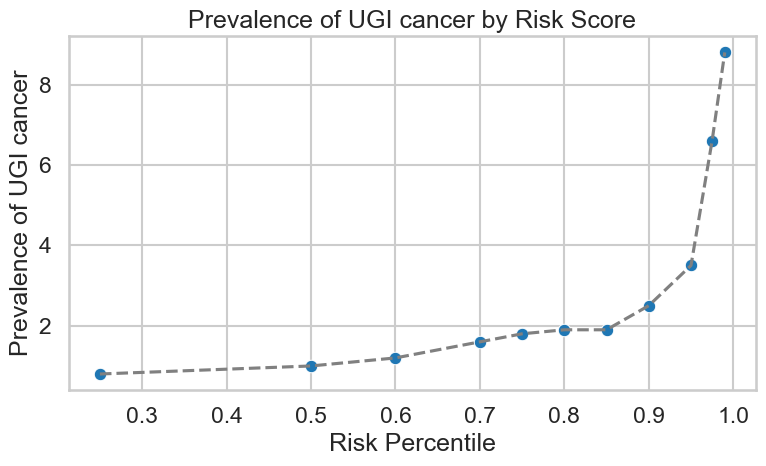

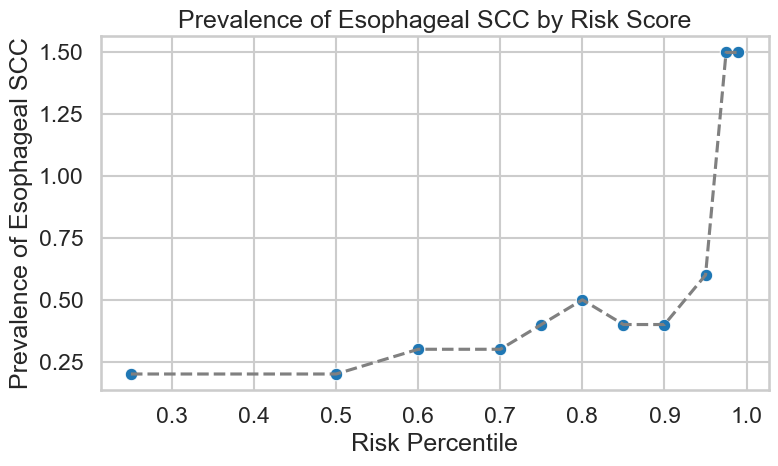

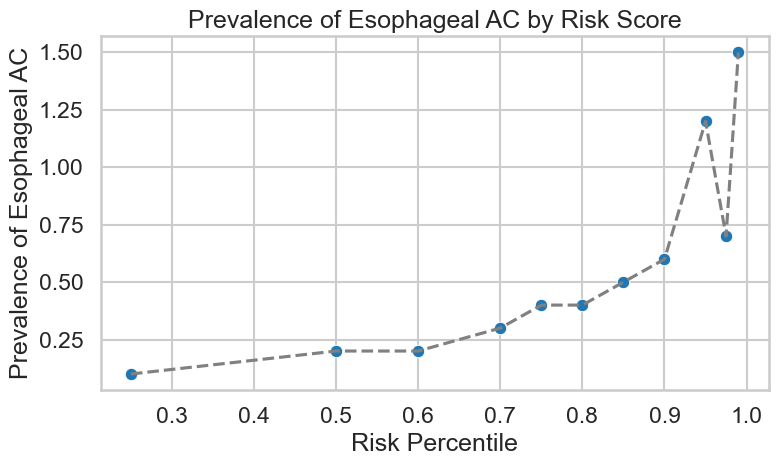

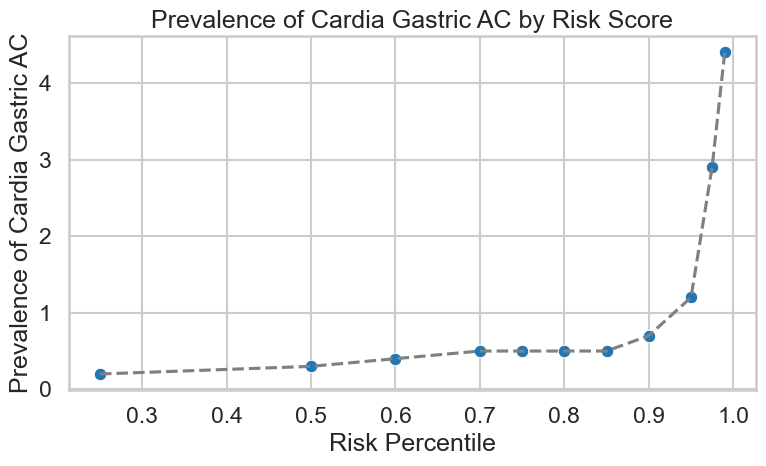

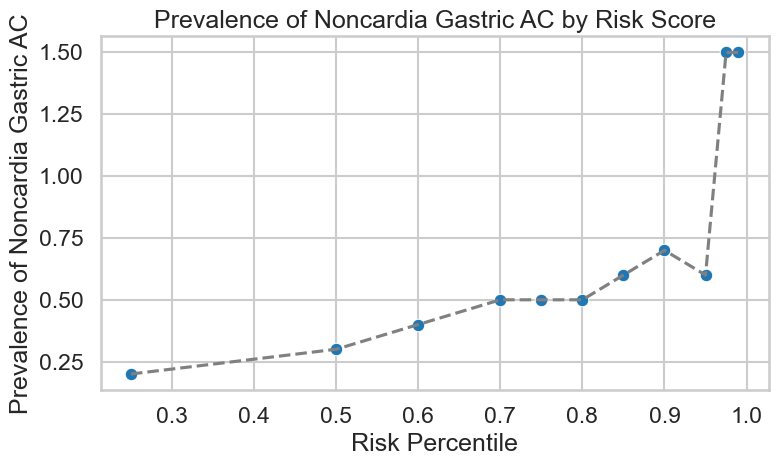

In [ ]:
for event in events_5yr:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results[df_results.event == event], x='risk_percentile', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results[df_results.event == event], x='risk_percentile', y='prevalence', color='gray', linestyle='--')

    plt.xlabel("Risk Percentile")
    #plt.xticks(ticks=range(len(percentile_cutoffs)-1), labels=percentile_cutoffs[1:])
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}')
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_75047/2150258601.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('risk_group')[event]


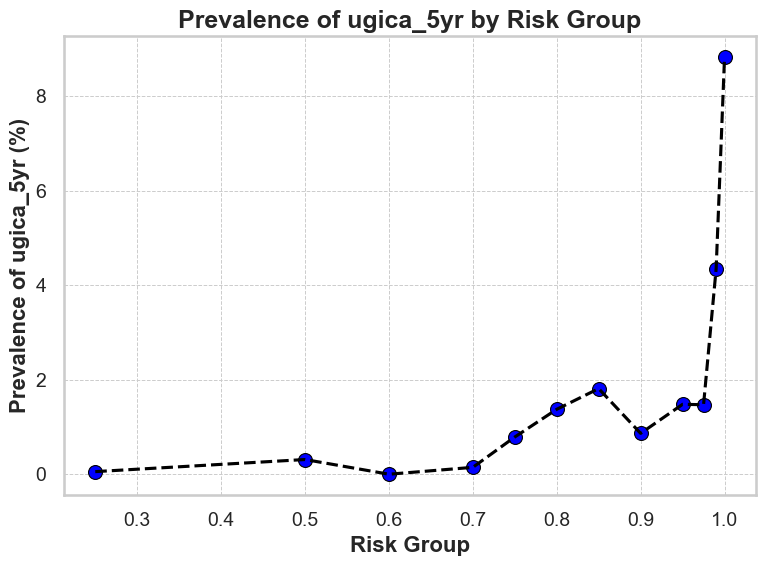

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_75047/2150258601.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('risk_group')[event]


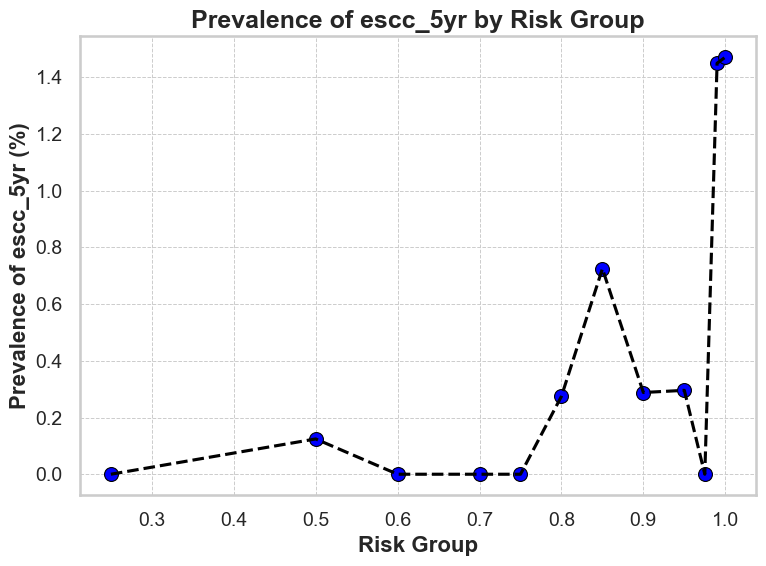

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_75047/2150258601.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('risk_group')[event]


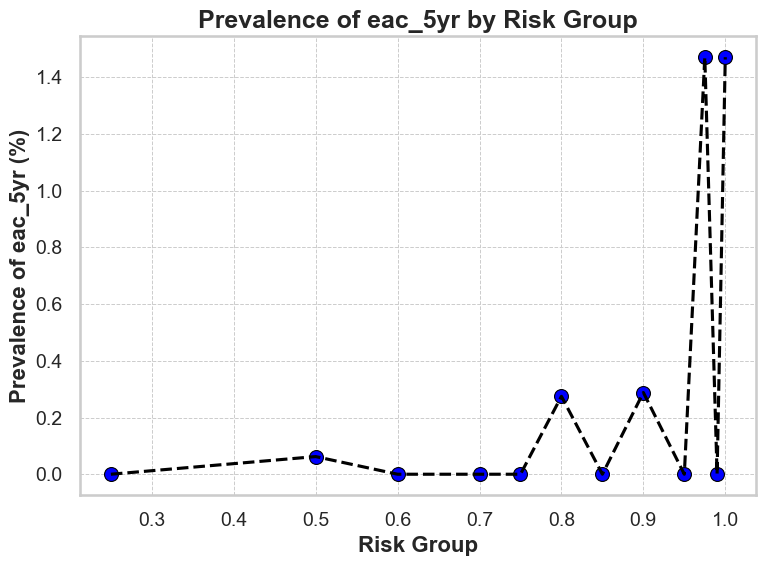

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_75047/2150258601.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('risk_group')[event]


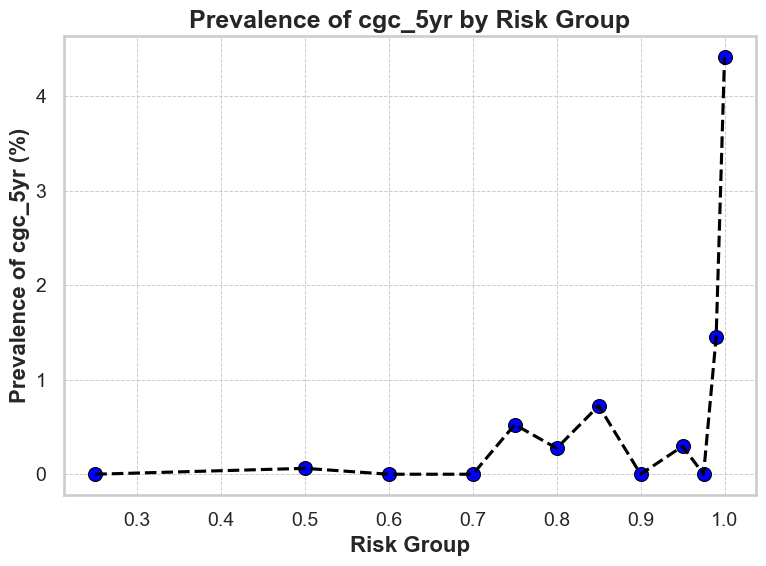

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_75047/2150258601.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('risk_group')[event]


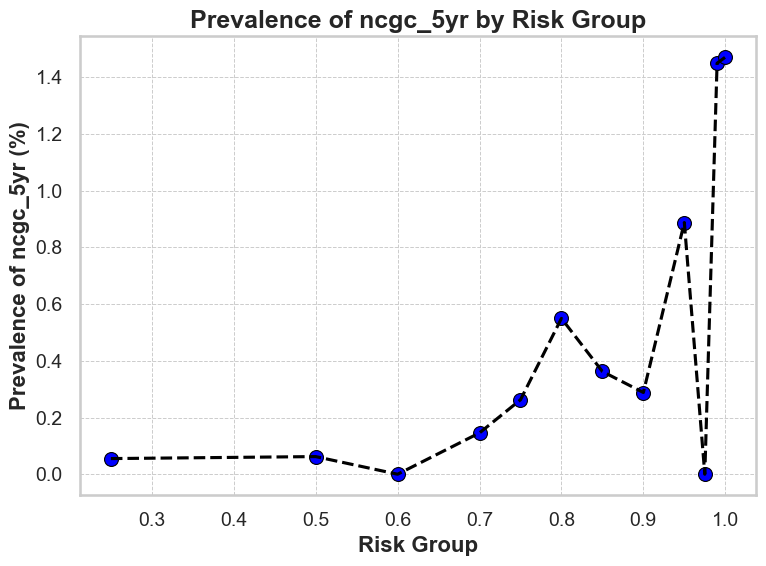

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style for publication quality
sns.set_style("whitegrid")
sns.set_context("talk")  # Larger font sizes

for event in events_5yr:
    # Group by risk group and calculate prevalence
    prevalence_df = (
        df_validation_risk
        .groupby('risk_group')[event]
        .mean() * 100
    ).reset_index().rename(columns={event: 'prevalence'})

    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Scatterplot of prevalence
    sns.scatterplot(data=prevalence_df, x='risk_group', y='prevalence', s=100, color='blue', edgecolor='black')

    # Line plot to connect the points
    sns.lineplot(data=prevalence_df, x='risk_group', y='prevalence', color='black', linestyle='--')

    # Customize labels and title
    plt.xlabel("Risk Group", fontsize=16, fontweight='bold')
    plt.ylabel(f"Prevalence of {event} (%)", fontsize=16, fontweight='bold')
    plt.title(f"Prevalence of {event} by Risk Group", fontsize=18, fontweight='bold')

    # Adjust ticks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Add grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)

    # Tight layout and show
    plt.tight_layout()
    plt.show()


### Kaplan Meier survival curves stratified by risk group

In [ ]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk_youden)

high_risk_youden,0,1
ugica_5yr,,
0.0,5112,1684
1.0,8,32


In [ ]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk)

high_risk,0,1
ugica_5yr,,
0.0,6463,333
1.0,35,5


In [ ]:
# Pass dataframe to R to analyze
pass_df(df_validation_risk, 'r_df_validation_risk')

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "risk_group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


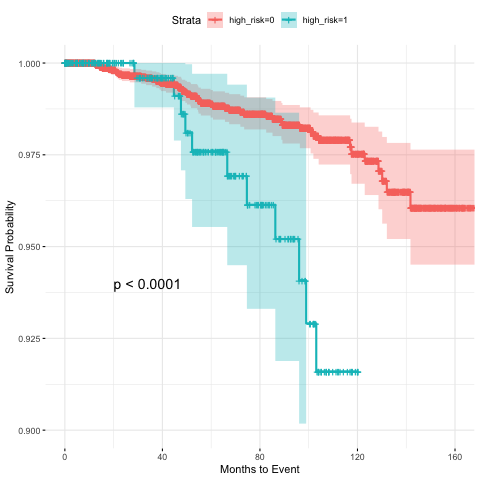

In [ ]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot

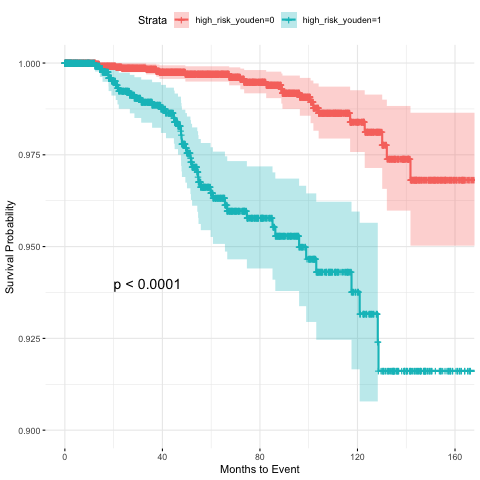

In [ ]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot

### Save model, threshold and validation set

In [ ]:
%%R 
# Save model
saveRDS(cox_model, "coxph_all.rds")

In [ ]:
# Save optimal threshold 
import json
import os

def save_to_json(variable, filename, key=None):
    # If the file exists, load existing data
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    # Append or update data
    if key in data:
        data[key].update(variable)
    else: 
        data[key] = variable

    # Save the updated data
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Saved to {filename}")


In [ ]:
model = 'coxph'
subtype = 'combined'
selected_vars = list(r['selected_vars'])  

model_variables = {
    subtype: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
